In [2]:
import pandas as pd
import xarray as xr
import numpy as np
import glob
from os.path import join
import matplotlib.pyplot as plt

In [94]:
def create_xy_data(intermediate_path, param_file_path, variable, start_year=1901, end_year=2000):

    """ This function depends on a file path to intermediate processed files of CLM output (by year) that each contain
    variable information for all 500 ensemble members. See 'intermediate_data_gen.ipynb' notebook for how
    to generate that data.

    For the output data, this funciton loads all of the data available, subsets, and stacks the CLM data into a 
    Machine learning ingestible format. 
    
    For the input data, it loads the parameters of the CLM ensemble and duplicates it to match the size of the stacked
    output data. Additioinally, it adds transformed date features (cos and sin transformations of month, and year) to 
    make each sample unique. 
    
    For the output data, it preserves the sparse grid (400 grid cells) for the specified variable, with a multi-index
    of [ensemble member, time] 
    """    
    
    CLM_data_files = sorted(glob.glob(join(intermediate_path, "*.nc")))
    CLM_data = xr.open_mfdataset(CLM_data_files, parallel=True).sel(time=slice(f"{start_year}", f"{end_year}"))
    
    n_time_steps = len(CLM_data.time)
    CLM_data = CLM_data.stack({'sample': ('member', 'time')})
    dates = pd.to_datetime(CLM_data['time'].dt.strftime("%Y-%m-%d"))
    members = CLM_data['member'].values
    
    years = CLM_data.time.dt.year.values
    months = CLM_data.time.dt.month.values
    period = 12 # number of months
    m_sin = np.sin(months / period * 2 * np.pi)
    m_cos = np.cos(months / period * 2 * np.pi)
    
    ensemble_parameters = pd.read_csv(param_file_path).drop(columns='member')
    x_data = ensemble_parameters.iloc[np.repeat(np.arange(len(ensemble_parameters)), n_time_steps)].copy().astype('float32')
    x_data.loc[:, ('m_sin')] = m_sin.astype('float32')
    x_data.loc[:, ('m_cos')] = m_cos.astype('float32')
    x_data.loc[:, ('year')] = years.astype('int32')
    x_data['member'] = members
    x_data['time'] = dates
    x_data.set_index(["member", "time"], inplace=True)

    y_data = CLM_data[variable].T.to_pandas().astype('float32').reset_index()
    y_data.loc[:, ('time')] = dates
    y_data.set_index(["member", "time"], inplace=True)
    y_data.columns = y_data.columns.astype(str)
    
    return x_data, y_data

In [104]:
%%time
variable = "GPP"
x, y = create_xy_data(intermediate_path="/glade/derecho/scratch/cbecker/PPE_intermediate_data/LAI/",
                      param_file_path="/glade/campaign/cgd/tss/projects/PPE/helpers/lhc220926.txt",
                      variable=variable,
                      start_year=1850,
                      end_year=2015)

CPU times: user 13.2 s, sys: 2.22 s, total: 15.5 s
Wall time: 11.1 s


In [105]:
x

FUN_fracfixers       KCN     a_fix  crit_dayl     d_max  \
member time                                                                  
1      1850-02-01        0.778311  0.358026  0.255021   0.401235  0.797847   
       1850-03-01        0.778311  0.358026  0.255021   0.401235  0.797847   
       1850-04-01        0.778311  0.358026  0.255021   0.401235  0.797847   
       1850-05-01        0.778311  0.358026  0.255021   0.401235  0.797847   
       1850-06-01        0.778311  0.358026  0.255021   0.401235  0.797847   
...                           ...       ...       ...        ...       ...   
500    2014-09-01        0.422114  0.839212  0.144342   0.657058  0.400938   
       2014-10-01        0.422114  0.839212  0.144342   0.657058  0.400938   
       2014-11-01        0.422114  0.839212  0.144342   0.657058  0.400938   
       2014-12-01        0.422114  0.839212  0.144342   0.657058  0.400938   
       2015-01-01        0.422114  0.839212  0.144342   0.657058  0.400938   

                        fff  froot_leaf  fstor2tran    grperc    jmaxb0  ...  \
member time                                                              ...   
1      1850-02-01  0.130074    0.938827    0.378388  0.196517  0.624727  ...   
       1850-03-01  0.130074    0.938827    0.378388  0.196517  0.624727  ...   
       1850-04-01  0.130074    0.938827    0.378388  0.196517  0.624727  ...   
       1850-05-01  0.130074    0.938827    0.378388  0.196517  0.624727  ...   
       1850-06-01  0.130074    0.938827    0.378388  0.196517  0.624727  ...   
...                     ...         ...         ...       ...       ...  ...   
500    2014-09-01  0.027978    0.969087    0.198452  0.025192  0.612521  ...   
       2014-10-01  0.027978    0.969087    0.198452  0.025192  0.612521  ...   
       2014-11-01  0.027978    0.969087    0.198452  0.025192  0.612521  ...   
       2014-12-01  0.027978    0.969087    0.198452  0.025192  0.612521  ...   
       2015-01-01  0.027978    0.969087    0.198452  0.025192  0.612521  ...   

                   soilpsi_off  stem_leaf  sucsat_sf  theta_cj  tpu25ratio  \
member time                                                                  
1      1850-02-01     0.137397   0.113845   0.798198  0.036459    0.393617   
       1850-03-01     0.137397   0.113845   0.798198  0.036459    0.393617   
       1850-04-01     0.137397   0.113845   0.798198  0.036459    0.393617   
       1850-05-01     0.137397   0.113845   0.798198  0.036459    0.393617   
       1850-06-01     0.137397   0.113845   0.798198  0.036459    0.393617   
...                        ...        ...        ...       ...         ...   
500    2014-09-01     0.285382   0.346998   0.651474  0.505517    0.212370   
       2014-10-01     0.285382   0.346998   0.651474  0.505517    0.212370   
       2014-11-01     0.285382   0.346998   0.651474  0.505517    0.212370   
       2014-12-01     0.285382   0.346998   0.651474  0.505517    0.212370   
       2015-01-01     0.285382   0.346998   0.651474  0.505517    0.212370   

                   tpuse_sf   wc2wjb0         m_sin         m_cos  year  
member time                                                              
1      1850-02-01  0.078962  0.684588  8.660254e-01  5.000000e-01  1850  
       1850-03-01  0.078962  0.684588  1.000000e+00  6.123234e-17  1850  
       1850-04-01  0.078962  0.684588  8.660254e-01 -5.000000e-01  1850  
       1850-05-01  0.078962  0.684588  5.000000e-01 -8.660254e-01  1850  
       1850-06-01  0.078962  0.684588  1.224647e-16 -1.000000e+00  1850  
...                     ...       ...           ...           ...   ...  
500    2014-09-01  0.363440  0.156710 -1.000000e+00 -1.836970e-16  2014  
       2014-10-01  0.363440  0.156710 -8.660254e-01  5.000000e-01  2014  
       2014-11-01  0.363440  0.156710 -5.000000e-01  8.660254e-01  2014  
       2014-12-01  0.363440  0.156710 -2.449294e-16  1.000000e+00  2014  
       2015-01-01  0.363440  0.156710  5.000000e-01  8.66025

In [106]:
y

gridcell                  0         1         2             3         4  \
member time                                                               
1      1850-02-01  0.000100  0.000087  0.000146  6.577203e-05  0.000003   
       1850-03-01  0.000089  0.000079  0.000123  6.142267e-05  0.000003   
       1850-04-01  0.000040  0.000039  0.000074  4.717219e-05  0.000003   
       1850-05-01  0.000009  0.000007  0.000007  8.362695e-06  0.000015   
       1850-06-01  0.000005  0.000004  0.000004  1.101665e-06  0.000014   
...                     ...       ...       ...           ...       ...   
500    2014-09-01  0.000018  0.000001  0.000037  9.392209e-07  0.000014   
       2014-10-01  0.000032  0.000003  0.000059  1.507567e-06  0.000020   
       2014-11-01  0.000055  0.000032  0.000097  3.555362e-05  0.000031   
       2014-12-01  0.000073  0.000058  0.000134  6.318940e-05  0.000035   
       2015-01-01  0.000093  0.000071  0.000148  7.216624e-05  0.000033   

gridcell                  5         6         7         8         9  ...  390  \
member time                                                          ...        
1      1850-02-01  0.000106  0.000013  0.000037  0.000036  0.000128  ...  0.0   
       1850-03-01  0.000095  0.000005  0.000060  0.000021  0.000111  ...  0.0   
       1850-04-01  0.000077  0.000011  0.000071  0.000040  0.000099  ...  0.0   
       1850-05-01  0.000042  0.000010  0.000062  0.000028  0.000079  ...  0.0   
       1850-06-01  0.000019  0.000036  0.000046  0.000031  0.000058  ...  0.0   
...                     ...       ...       ...       ...       ...  ...  ...   
500    2014-09-01  0.000038  0.000044  0.000050  0.000060  0.000061  ...  0.0   
       2014-10-01  0.000062  0.000063  0.000073  0.000082  0.000081  ...  0.0   
       2014-11-01  0.000081  0.000071  0.000095  0.000080  0.000107  ...  0.0   
       2014-12-01  0.000106  0.000058  0.000111  0.000072  0.000129  ...  0.0   
       2015-01-01  0.000118  0.000044  0.000111  0.000056  0.000136  ...  0.0   

gridcell           391  392  393  394  395  396  397  398  399  
member time                                                     
1      1850-02-01  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
       1850-03-01  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
       1850-04-01  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
       1850-05-01  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
       1850-06-01  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
...                ...  ...  ...  ...  ...  ...  ...  ...  ...  
500    2014-09-01  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
       2014-10-01  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
       2014-11-01  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
       2014-12-01  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
       2015-01-01  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[989500 rows x 400 columns]

In [107]:
# x has 600k samples with 35 features (32 LHC parameters, sin / cos transformation of month, and year)
# y has 600k samples with TWS (total water storage) for the sparse grid of 400 cells

x.shape, y.shape

((989500, 35), (989500, 400))

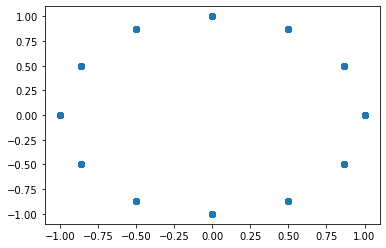

In [108]:
# quick demo of what the month transformations look like to preserve seasonality
plt.scatter(x['m_sin'], x['m_cos'])

In [109]:
x.to_parquet(f"/glade/derecho/scratch/cbecker/PPE_intermediate_data/LAI/ML_ready_data/{variable}_x_data.parquet")
y.to_parquet(f"/glade/derecho/scratch/cbecker/PPE_intermediate_data/LAI/ML_ready_data/{variable}_y_data.parquet")